<a href="https://colab.research.google.com/github/Jimmynycu/GuraQQ/blob/main/GuraQQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# 步驟 1：設定環境
!pip install google-api-python-client transformers torch networkx matplotlib seaborn wordcloud

import pandas as pd
import numpy as np
from googleapiclient.discovery import build
from transformers import pipeline
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import defaultdict
import re
from google.colab import drive

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

In [7]:
# 連接到Google Drive（可選）
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 替換為你的API金鑰和VTuber影片ID
API_KEY = ''  # 在Google Cloud Console獲取
VIDEO_ID = ''     # e.g., Hololive影片ID，從YouTube URL獲取

In [10]:
# 步驟 2：使用YouTube Data API收集數據
def get_youtube_comments(video_id, api_key, max_comments=100):
    youtube = build('youtube', 'v3', developerKey=API_KEY)
    comments = []
    next_page_token = None

    while len(comments) < max_comments:
        request = youtube.commentThreads().list(
            part='snippet',
            videoId=video_id,
            maxResults=100,
            pageToken=next_page_token
        )
        response = request.execute()

        for item in response['items']:
            comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
            author = item['snippet']['topLevelComment']['snippet']['authorDisplayName']
            comments.append({'author': author, 'comment': comment})

        next_page_token = response.get('nextPageToken')
        if not next_page_token or len(comments) >= max_comments:
            break

    return pd.DataFrame(comments)

Device set to use cpu


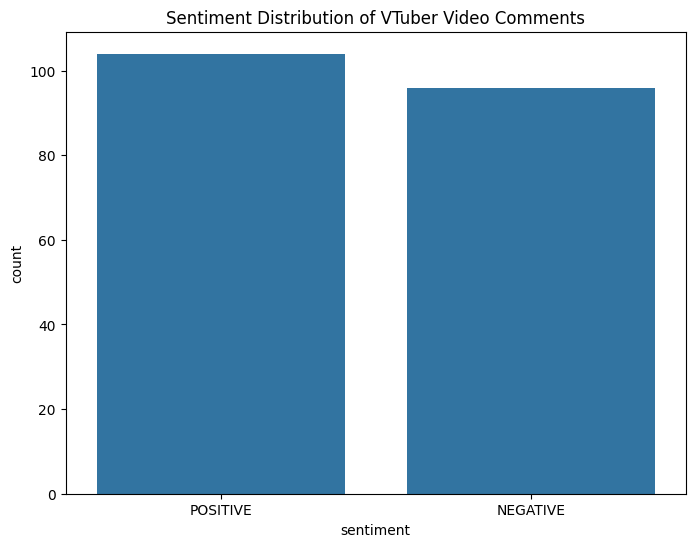

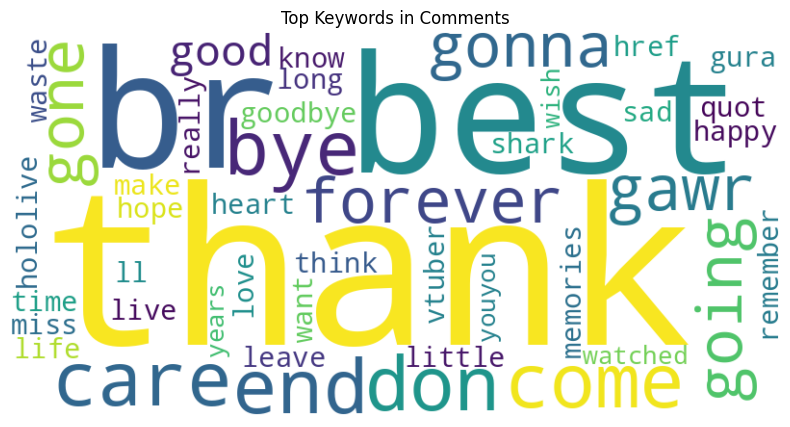

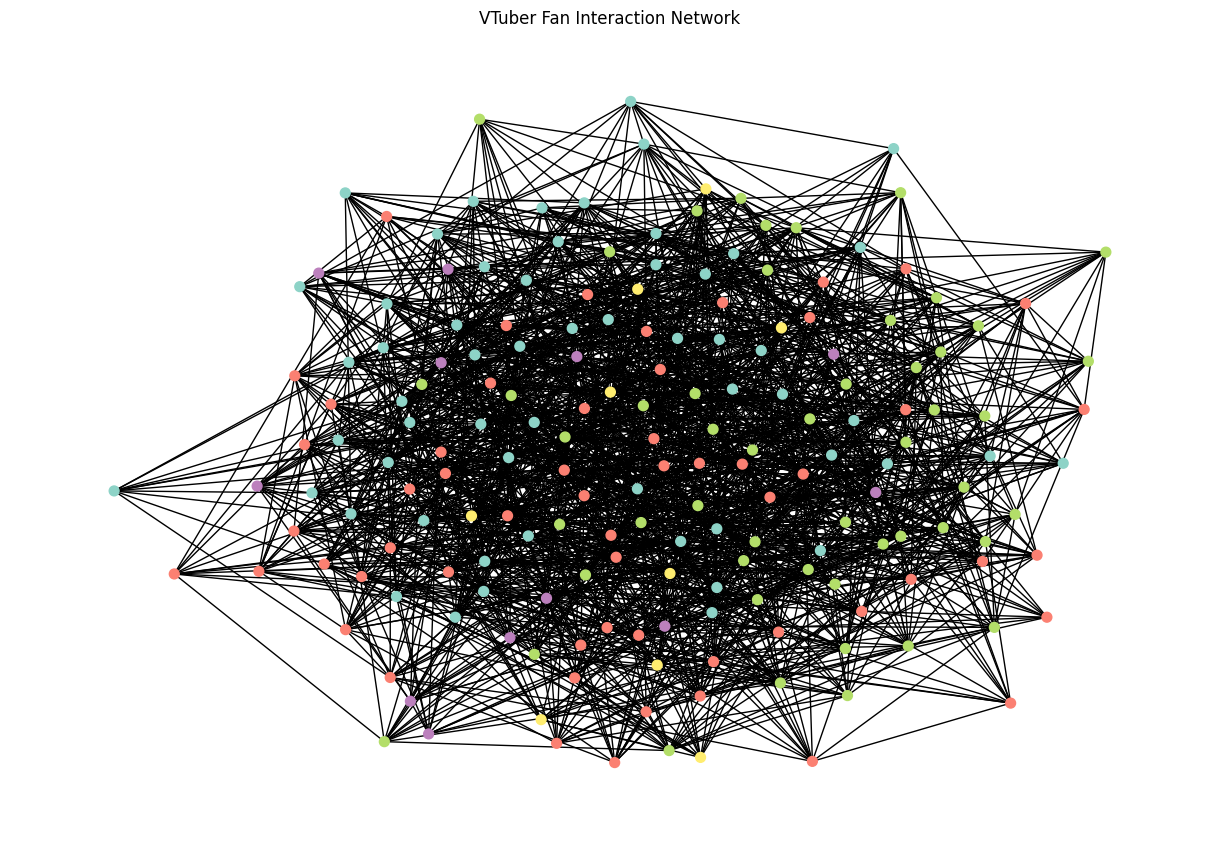

Top 5 Influencers (PageRank):
@S1_99tk: 0.0075
@Iyeyyyyyyy: 0.0075
@Meloy-Pokm: 0.0074
@OphisUroboros: 0.0071
@nycuagau...: 0.0071
Number of Communities: 5


In [13]:
# 獲取評論
comments_df = get_youtube_comments(VIDEO_ID, API_KEY, max_comments=200)
comments_df.to_csv('/content/drive/MyDrive/vtuber_comments.csv', index=False)

# 步驟 3：NLP分析 - 情感分析與關鍵詞提取
# 初始化Hugging Face情感分析模型
sentiment_analyzer = pipeline('sentiment-analysis', model='distilbert-base-uncased-finetuned-sst-2-english')

def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = text.lower()
    return text

# 清理評論並進行情感分析
comments_df['cleaned_comment'] = comments_df['comment'].apply(clean_text)
comments_df['sentiment'] = comments_df['cleaned_comment'].apply(
    lambda x: sentiment_analyzer(x[:512])[0]['label'] if x else 'NEUTRAL'
)
comments_df['sentiment_score'] = comments_df['cleaned_comment'].apply(
    lambda x: sentiment_analyzer(x[:512])[0]['score'] if x else 0.5
)

# 簡單關鍵詞提取（使用TF-IDF）
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=50, stop_words='english')
tfidf_matrix = tfidf.fit_transform(comments_df['cleaned_comment'])
keywords = tfidf.get_feature_names_out()

# 步驟 4：構建社群網絡
# 模擬互動網絡：假設同一影片下回覆同一評論的用戶有互動
G = nx.Graph()
user_interactions = defaultdict(set)

# 簡化：將同一影片下的用戶視為有潛在互動
for author in comments_df['author'].unique():
    G.add_node(author)

# 添加邊（假設隨機互動，實際可根據回覆結構）
np.random.seed(42)
authors = comments_df['author'].unique()
for i, author1 in enumerate(authors):
    for author2 in authors[i+1:]:
        if np.random.rand() < 0.1:  # 模擬10%互動機率
            G.add_edge(author1, author2)

# 計算PageRank
pagerank = nx.pagerank(G)
top_influencers = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:5]

# 社群檢測
communities = nx.algorithms.community.greedy_modularity_communities(G)
community_dict = {}
for i, comm in enumerate(communities):
    for node in comm:
        community_dict[node] = i

# 步驟 5：可視化
# 情感分佈
plt.figure(figsize=(8, 6))
sns.countplot(data=comments_df, x='sentiment')
plt.title('Sentiment Distribution of VTuber Video Comments')
plt.savefig('/content/drive/MyDrive/sentiment_distribution.png')
plt.show()

# 關鍵詞雲
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(keywords))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top Keywords in Comments')
plt.savefig('/content/drive/MyDrive/keyword_cloud.png')
plt.show()

# 網絡圖
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)
node_colors = [community_dict.get(node, 0) for node in G.nodes()]
nx.draw(G, pos, node_color=node_colors, node_size=50, cmap=plt.cm.Set3, with_labels=False)
plt.title('VTuber Fan Interaction Network')
plt.savefig('/content/drive/MyDrive/network_graph.png')
plt.show()

# 打印關鍵結果
print("Top 5 Influencers (PageRank):")
for influencer, score in top_influencers:
    print(f"{influencer}: {score:.4f}")
print(f"Number of Communities: {len(communities)}")